In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('..')
import rwpropa as rw

### Source

In [2]:
nr_particles = 1*10**4
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
energy = 10**12 # eV
sphere = 10**14 # [m]

def point_source(nr_particles=nr_particles):
    return rw.PointSourceIsotropic(energy, source_pos, nr_particles)

def sphere_source(nr_particles=nr_particles):
    radius = sphere
    source = rw.SphereSourceIsotropic(energy, source_pos, nr_particles, radius)
    return source

### Propagator

In [9]:
step_size = 1.0*10**12

def propagator(nr_steps=1*10**4, step_size=step_size, diff=1.5*10**21):
    speed_of_light = 3*10**8 # [m/s]
    diffusion_coefficient = diff # [m^2/s]
    mfp_iso = 3*diffusion_coefficient/speed_of_light
    mfp = np.array([mfp_iso, mfp_iso, mfp_iso], dtype=np.float32)  # [m]
    prop = rw.IsotropicPropagator(mfp, nr_steps, step_size)
    return prop

### Observer

In [10]:
def time_evolution_observer(nr_steps):
    substeps = [False, False, True] # observe only steps (no substeps)
    min_step = 1
    max_step = nr_steps
    nr_obs_steps = 30
    observer = rw.TimeEvolutionObserverLog(min_step, max_step, nr_obs_steps, substeps)
    return observer

def sphere_observer(deactivate=True):
    substeps = [False, False, True] # observe only steps (no substeps)
    spheres = [sphere]
    return rw.SphericalObserver(substeps, spheres, on_detection_deactivate=deactivate)

### Simulation & Analyze setup

In [11]:
def run_simulation(source, observer, propagator, file_name):
    sim = rw.Simulation()
    sim.add_source(source)
    sim.add_propagator(propagator)
    sim.add_observer(observer)
    %time sim.run_simulation()
    sim.save_data(file_name)

In [6]:
def analize(file_name, diff, nr_particles=nr_particles):
    df = pd.read_pickle(file_name+'.pkl')
    bins = 20
    trajectory_lengths = df['d']
    d = trajectory_lengths/10**14
    hist, bins = np.histogram(d, bins=bins)
    logbins = np.logspace(np.log10(min(d)),np.log10(max(d)),len(bins))
    plt.hist(d, bins=logbins, alpha=0.5, label='$\kappa =$ {:.1e}m$^2$/s'.format(diff))

    plt.title('total # particles = {:.0e}'.format(nr_particles))
    plt.xlabel('D/{:.0e}m'.format(sphere))
    plt.ylabel('# particles')
    plt.loglog()
    plt.legend()
    plt.show()

###  Simulation

In [12]:
diff = 10**21 #[m^2/s]

Observer initialized
Propagator initialized
start simulation
CPU times: user 2.9 s, sys: 15.9 ms, total: 2.92 s
Wall time: 2.92 s
saved data file data/data_tut_5_point_time_kappa.pkl
init statistics plotting class


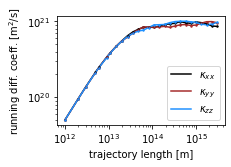

diffusion coefficients computed between 9.94e+14m and 3.00e+15m with 5 data points
kappa_{xx}: 9.23e+20 m²/s +- 4.97e+19 m²/s
kappa_{yy}: 9.59e+20 m²/s +- 3.57e+19 m²/s
kappa_{zz}: 9.38e+20 m²/s +- 2.76e+19 m²/s

-----------------------------------
particle distribution after 1. step


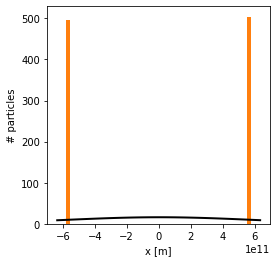


-----------------------------------
particle distribution after last step


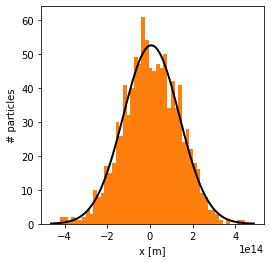

,id,i,d,x,y,z,phi,pitch_angle,radius,sub_step
0,0.0,1.0,1.000000e+12,-5.773503e+11,-5.773503e+11,5.773503e+11,1.809310,2.466364,-1.0,2.0
1,0.0,2.0,2.000000e+12,-1.154701e+12,-1.154701e+12,1.154701e+12,1.809310,2.466364,-1.0,2.0
2,0.0,3.0,3.000000e+12,-1.732051e+12,-1.732051e+12,1.732051e+12,1.809310,2.466364,-1.0,2.0
3,0.0,5.0,5.000000e+12,-2.886751e+12,-2.886751e+12,2.886751e+12,1.809310,2.466364,-1.0,2.0
4,0.0,6.0,6.000001e+12,-3.464101e+12,-3.464101e+12,3.464101e+12,1.809310,2.466364,-1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
26995,999.0,994.0,9.939901e+14,5.773506e+12,-4.849741e+13,-5.658032e+13,4.764899,2.588378,-1.0,2.0
26996,999.0,1310.0,1.310024e+15,-5.658031e+13,-4.965211e+13,-5.080682e+13,4.764899,2.588378,-1.0,2.0
26997,999.0,1727.0,1.727103e+15,-1.327905e+13,2.713546e+13,-1.732059e+12,4.764899,2.588378,-1.0,2.0
26998,999.0,2276.0,2.276208e+15,-2.193931e+13,-6.697262e+13,1.085421e+14,4.764899,2.588378,-1.0,2.0


In [16]:
file_0 = 'data/data_tut_5_point_time_kappa'
nr_steps = 3*10**3
run_simulation(point_source(nr_particles=10**3), time_evolution_observer(nr_steps=nr_steps), propagator(step_size=step_size, diff=diff, nr_steps=nr_steps), file_0)
df = pd.read_pickle(file_0+'.pkl')
sta = rw.Statistics(df)
df_kappas = sta.plot_diffusion_coefficients(n_points_plateau=5)

steps = sorted(list(set(df['i'])))
print('\n-----------------------------------')
print('particle distribution after '+str(int(steps[0]))+'. step')
sta.plot_distribution('x', steps[0], 50, None)
print('\n-----------------------------------')
print('particle distribution after last step')
sta.plot_distribution('x', steps[-1], 50, None)
df

Observer initialized
Propagator initialized
start simulation
CPU times: user 3.44 s, sys: 3.94 ms, total: 3.44 s
Wall time: 3.44 s
saved data file data/data_tut_5_source_time_distr.pkl
init statistics plotting class

-----------------------------------
particle distribution after 1. step


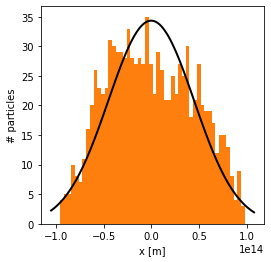


-----------------------------------
particle distribution after last step


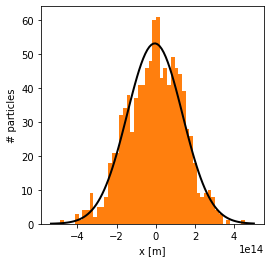

In [17]:
file_1 = 'data/data_tut_5_source_time_distr'
nr_steps=3*10**3
run_simulation(sphere_source(nr_particles=10**3), time_evolution_observer(nr_steps=nr_steps), propagator(step_size=step_size, diff=diff, nr_steps=nr_steps), file_1)
df = pd.read_pickle(file_1+'.pkl')
sta = rw.Statistics(df)
steps = sorted(list(set(df['i'])))
print('\n-----------------------------------')
print('particle distribution after '+str(int(steps[0]))+'. step')
sta.plot_distribution('x', steps[0], 50, None)
print('\n-----------------------------------')
print('particle distribution after last step')
sta.plot_distribution('x', steps[-1], 50, None)

Observer initialized
Propagator initialized
start simulation
CPU times: user 8.77 s, sys: 3.88 ms, total: 8.77 s
Wall time: 8.77 s
saved data file data/data_tut_5_point_sphere_hist.pkl


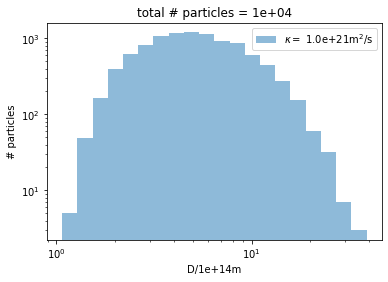

In [18]:
file_2 = 'data/data_tut_5_point_sphere_hist'
run_simulation(point_source(), sphere_observer(), propagator(step_size=step_size, diff=diff, nr_steps=1*10**4), file_2)
analize(file_2, diff)

Observer initialized
Propagator initialized
start simulation
CPU times: user 4.6 s, sys: 0 ns, total: 4.6 s
Wall time: 4.6 s
saved data file data/data_tut_5_sphere_sphere.pkl


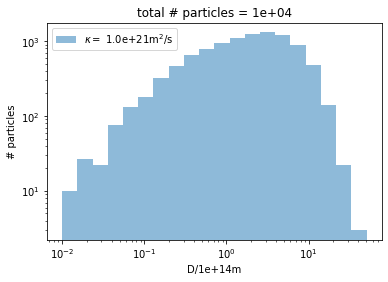

In [19]:
file_3 = 'data/data_tut_5_sphere_sphere'
run_simulation(sphere_source(), sphere_observer(), propagator(step_size=step_size, diff=diff, nr_steps=1*10**4), file_3)
analize(file_3, diff)

Observer initialized
Propagator initialized
start simulation
CPU times: user 115 ms, sys: 3.99 ms, total: 119 ms
Wall time: 118 ms
saved data file data/data_tut_5_sphere_sphere_active.pkl


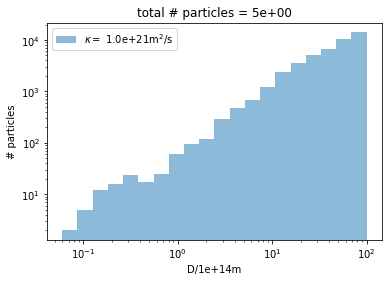

In [20]:
file_4 = 'data/data_tut_5_sphere_sphere_active'
run_simulation(sphere_source(nr_particles=5), sphere_observer(deactivate=False), propagator(step_size=step_size, diff=diff, nr_steps=1*10**4), file_4)
analize(file_4, diff, nr_particles=5)

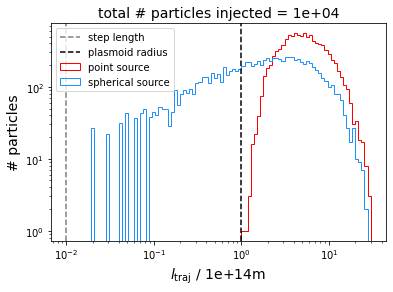

In [21]:
colors = ['r', 'dodgerblue']
labels = ['point source', 'spherical source']
bins = 100
logbins = np.logspace(np.log10(step_size/sphere), np.log10(step_size*nr_steps/sphere),bins)

for i, file in enumerate([file_2, file_3]):
    df = pd.read_pickle(file+'.pkl')
    trajectory_lengths = df['d']
    d = trajectory_lengths/sphere
    plt.hist(d, bins=logbins, histtype=u'step', edgecolor=colors[i], linewidth=1., facecolor="None", label=labels[i])

plt.axvline(x=step_size/sphere, color='grey', ls='--', label='step length')
plt.axvline(x=1, color='k', ls='--', label='plasmoid radius')

plt.title('total # particles injected = {:.0e}'.format(nr_particles), size=14)
plt.xlabel('$l_\mathrm{traj}$'+' / {:.0e}m'.format(sphere), size=14)
plt.ylabel('# particles', size=14)
plt.loglog()
plt.legend(loc = "upper left")
#plt.savefig('traj_lengths_comparison_rwpropa.pdf')
plt.show()

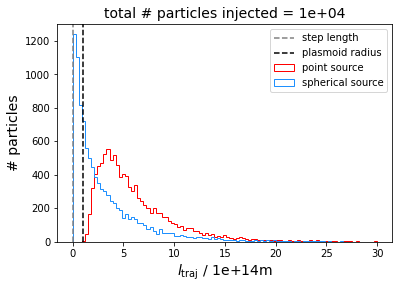

In [25]:
colors = ['r', 'dodgerblue']
labels = ['point source', 'spherical source']
bins = 100
linbins = np.linspace(step_size/sphere, (step_size*nr_steps/sphere),bins)

for i, file in enumerate([file_2, file_3]):
    df = pd.read_pickle(file+'.pkl')
    trajectory_lengths = df['d']
    d = trajectory_lengths/sphere
    plt.hist(d, bins=linbins, histtype=u'step', edgecolor=colors[i], linewidth=1., facecolor="None", label=labels[i])

plt.axvline(x=step_size/sphere, color='grey', ls='--', label='step length')
plt.axvline(x=1, color='k', ls='--', label='plasmoid radius')

plt.title('total # particles injected = {:.0e}'.format(nr_particles), size=14)
plt.xlabel('$l_\mathrm{traj}$'+' / {:.0e}m'.format(sphere), size=14)
plt.ylabel('# particles', size=14)
plt.legend(loc = "upper right")
plt.show()